In [ ]:
# sample data
import numpy as np
import pandas as pd
import yfinance as yf 
a = np.array([[1, 2], [3, 4]])
b = np.array([[1], [3]])
np.dot(a, b)

df1 = yf.download(["AAPL", "GOOG", "TSLA"], start="2024-01-01")
df = np.log(1+df1["Adj Close"].pct_change())

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import json
import yfinance as yf
import matplotlib.pyplot as plt
# calculations
def getLogReturnByStockPrice(df) -> pd.DataFrame:
    df1 = np.log(1+df.pct_change())
    return df1
def portfolioReturn(df, weights):
    return np.dot(df.mean(), weights)

def portfolioStd(df, weights, year=250):
    return np.dot(np.dot(df.cov(), weights), weights) ** (1/2) * np.sqrt(year)

def weightsCreator(df):
    rand = np.random.random(len(df.columns))
    rand /= rand.sum()
    return rand

def getWeightsByMontecarlo(stock_price_df, num=10000):
    df = getLogReturnByStockPrice(stock_price_df)
    returns = []
    stds = []
    w = []
    for _ in range(num):
        weights = weightsCreator(df)
        
        returns.append(portfolioReturn(df, weights)) # weighted return
        stds.append(portfolioStd(df, weights, 250)) # portfolio stadnard deviation vector calc
        w.append(weights)

    min_std = min(stds)
    index_min = stds.index(min_std)
    return w[index_min]

def getDF(codename_list, start_time, end_time):
    df = pd.DataFrame()
    for codename in codename_list:
            try:
                symbol = tw_stock_symbol_code[codename]
            except:
                symbol = tw_stock_symbol_code[check[codename]]
            data = pd.read_csv(f"../DB/TW/{symbol}.csv", index_col="Date")
            data_adj = data.loc[(data.index >= start_time) & (data.index <= end_time)]["Adj Close"]
            data_adj.name = symbol
            df = pd.concat([df, data_adj], axis=1)

    df.dropna(inplace=True)
    return df

def getNavSeries(df_now_for_nav, nav_current = 1):
    df2 = (1 + df_now_for_nav.pct_change()).cumprod()
    df3 = df2.fillna(1)
    df4 = df3*nav_current
    nav_series = np.sum(df4 * weighting, axis=1)
    nav = nav_series.iloc[-1]
    return nav_series, nav

fitting_num = 1000
start="2017-09-27"
end="2023-12-30"


# 前置資料: 股票代號中文對照(tw_stock_symbol_code)、各期成分股(data)、換股時間(time_start_end)
location = "../0056成份股季調整生效日期.xlsx"
time_df = pd.read_excel(location)
time_start_end = time_df.iloc[:, :2]

# 有對照錯誤的股票中文名稱
check = {'聚陽實業':'聚陽',
         "矽品": "矽品精密",
         "仁寶電腦":"仁寶",
         "群創光電":"群創",
         "微星科技":"微星",
         "智邦科技":"智邦",
         "群光電子":"群光",
         "聯強國際":"聯強",
         "創見資訊":"創見"
}

with open("../DB/0056_Ingred.json", "r", encoding="UTF-8") as f:
    data = json.load(f)

with open("../DB/tw_stock_symbol_code.json", "r") as f:
    tw_stock_symbol_code = json.load(f)

nav_current = 1
nav_all = pd.Series()
# ['17Q4', "18Q1"]
for i, season in enumerate(list(data.keys())):
    print(season)
    start_time = datetime.strftime(time_start_end.iloc[i, 0], "%Y-%m-%d")
    end_time = datetime.strftime(time_start_end.iloc[i, 1], "%Y-%m-%d")
    if i == 0:
        start_time_var = "2017-06-26"
        end_time_var = "2017-09-26"
    else:
        start_time_var = datetime.strftime(time_start_end.iloc[i-1, 0], "%Y-%m-%d")
        end_time_var = datetime.strftime(time_start_end.iloc[i-1, 1], "%Y-%m-%d")

    # print(var_dict)
    df_previous_for_weighting = getDF(data[season], start_time_var, end_time_var)
    weighting = getWeightsByMontecarlo(df_previous_for_weighting, fitting_num)
    
    df_now_for_nav = getDF(data[season], start_time, end_time)
    
    nav_series, nav_current = getNavSeries(df_now_for_nav, nav_current)
    nav_all = pd.concat([nav_all, nav_series], axis=0)


zero56 = yf.download("0056.TW", start=start, end=end)
zero56_cumprod = (1 + zero56['Adj Close'].pct_change()).cumprod()
zero56_cumprod = zero56_cumprod.fillna(1)
zero56_cumprod = pd.Series(zero56_cumprod, index=nav_all.index)
# plt.plot(nav_all, label='nav_new')

# zero56 = yf.download("0056.TW", start=start, end=end)
# zero56_cumprod = (1 + zero56['Adj Close'].pct_change()).cumprod()
# zero56_cumprod = zero56_cumprod.fillna(1)
# zero56_cumprod = pd.Series(zero56_cumprod, index=nav_all.index)
# plt.plot(zero56_cumprod, color='red', label='0056 Origin')

# plt.title("0056 vs Minimum Variance 0056")
# plt.legend(loc='upper left')
# plt.xticks()
# plt.plot()

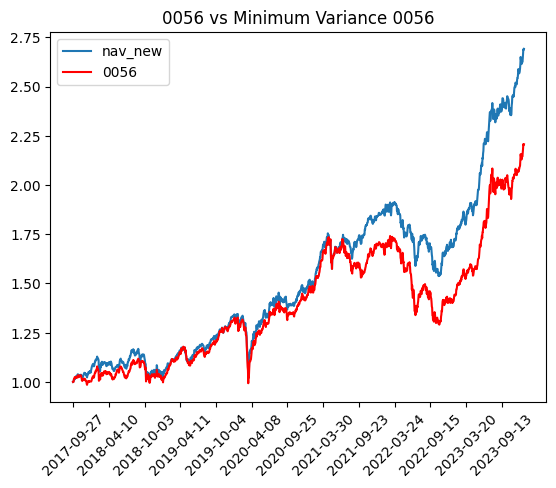

In [51]:
plt.plot(nav_all, label='nav_new')
plt.plot(zero56_cumprod, color='red', label='0056')

plt.title("0056 vs Minimum Variance 0056")
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.xticks(nav_all.index[::120])
plt.plot()
plt.savefig("comp_c1.png")

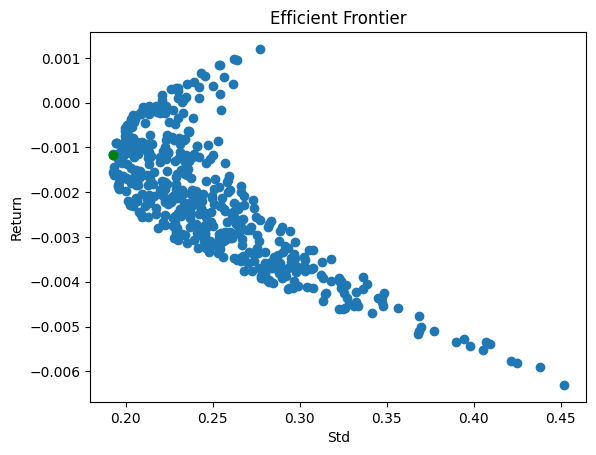

In [48]:
# Efficient Frontier
num = 500
df = getLogReturnByStockPrice(df_previous_for_weighting)
returns = []
stds = []
w = []
for _ in range(num):
    weights = weightsCreator(df)
    
    returns.append(portfolioReturn(df, weights)) # weighted return
    stds.append(portfolioStd(df, weights, 250)) # portfolio stadnard deviation vector calc
    w.append(weights)

min_std = min(stds)
index_min = stds.index(min_std)
plt.scatter(stds, returns)
plt.scatter(min(stds), returns[stds.index(min(stds))], color="green")
plt.title("Efficient Frontier")
plt.xlabel("Std")
plt.ylabel("Return")
plt.show()

min_std = min(stds)
index_min = stds.index(min_std)
print("return of min portfolio stds: ", returns[index_min])
print("minimum std: ", min_std)
print("weights: ", w[index_min])